# Importing necceasry libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tabulate import tabulate
import gradio as gr
import warnings
warnings.filterwarnings("ignore")

# Developing Logistic Regression and Random Forest Model


[+] Loading dataset...

[+] Performing feature selection using SelectKBest...

[+] SelectKBest Feature Selection Results:
+----------------------+----------------------+
| Feature              |   ANOVA F-test Score |
+======================+======================+
| concave points_worst |              733.725 |
+----------------------+----------------------+
| perimeter_worst      |              717.246 |
+----------------------+----------------------+
| radius_worst         |              692.861 |
+----------------------+----------------------+
| concave points_mean  |              684.527 |
+----------------------+----------------------+
| perimeter_mean       |              548.413 |
+----------------------+----------------------+
| area_worst           |              522.189 |
+----------------------+----------------------+
| radius_mean          |              511.275 |
+----------------------+----------------------+
| area_mean            |              444.858 |
+------------

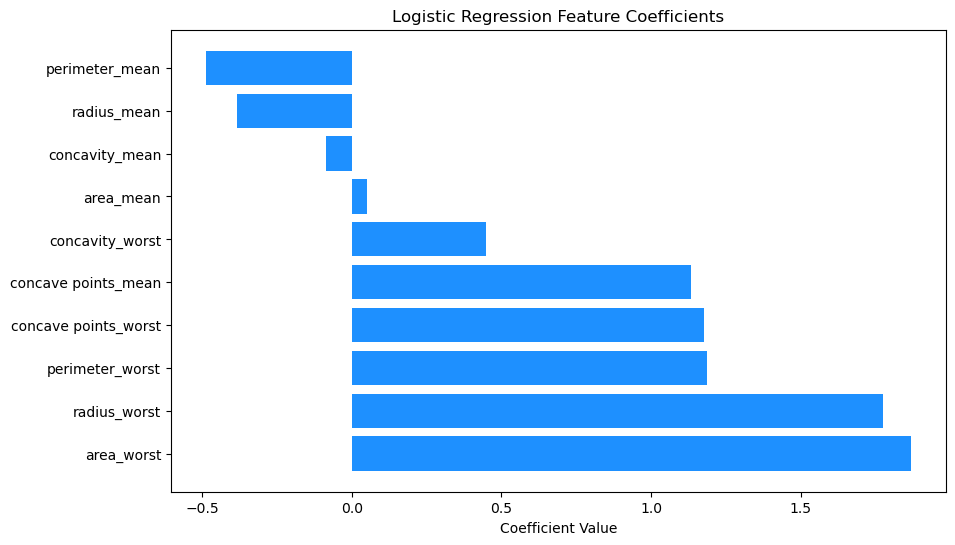


[+] Logistic Regression Model Evaluation:

Logistic Regression Model Performance Summary:
+----------------------------------+----------+
| Metric                           |    Value |
+==================================+==========+
| Cross-Validation Accuracy (Mean) | 0.953846 |
+----------------------------------+----------+
| Training Accuracy                | 0.956044 |
+----------------------------------+----------+
| Test Accuracy                    | 0.95614  |
+----------------------------------+----------+
| Precision (Benign)               | 0.946667 |
+----------------------------------+----------+
| Recall (Benign)                  | 0.986111 |
+----------------------------------+----------+
| F1-Score (Benign)                | 0.965986 |
+----------------------------------+----------+
| Precision (Malignant)            | 0.974359 |
+----------------------------------+----------+
| Recall (Malignant)               | 0.904762 |
+----------------------------------+---------

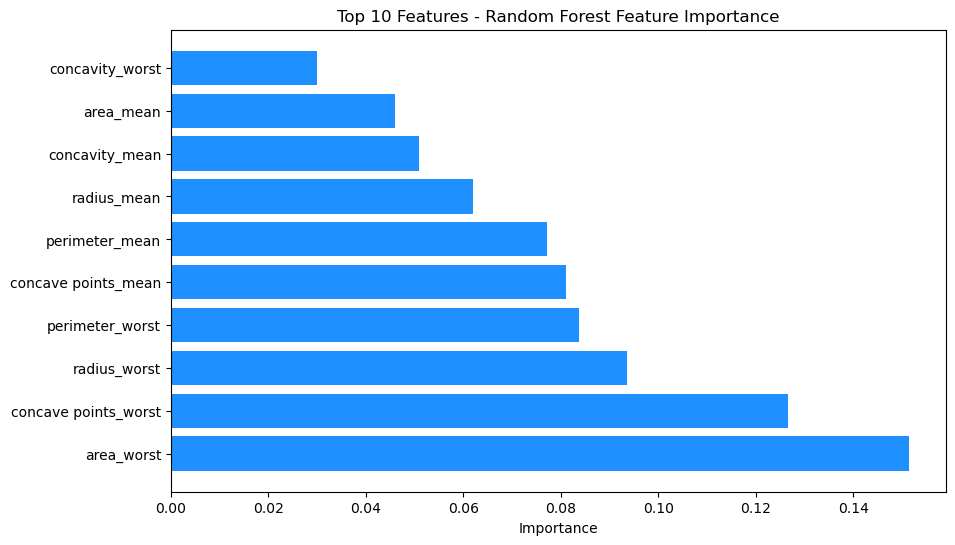


[+] Training Random Forest model with cross-validation...

[+] Random Forest Model Evaluation:

Random Forest Model Performance Summary:
+----------------------------------+----------+
| Metric                           |    Value |
+==================================+==========+
| Cross-Validation Accuracy (Mean) | 0.947253 |
+----------------------------------+----------+
| Training Accuracy                | 1        |
+----------------------------------+----------+
| Test Accuracy                    | 0.947368 |
+----------------------------------+----------+
| Precision (Benign)               | 0.934211 |
+----------------------------------+----------+
| Recall (Benign)                  | 0.986111 |
+----------------------------------+----------+
| F1-Score (Benign)                | 0.959459 |
+----------------------------------+----------+
| Precision (Malignant)            | 0.973684 |
+----------------------------------+----------+
| Recall (Malignant)               | 0.880952 

In [2]:
print("\n[+] Loading dataset...")
df = pd.read_csv("Cancer_data.csv")
df = df.drop(columns=['id', 'Unnamed: 32'])

df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n[+] Performing feature selection using SelectKBest...")
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]
selected_features_log_reg=selected_features
feature_scores = selector.scores_[selector.get_support()]

selectkbest_results = pd.DataFrame({
    'Feature': selected_features,
    'ANOVA F-test Score': feature_scores
}).sort_values(by='ANOVA F-test Score', ascending=False)

print("\n[+] SelectKBest Feature Selection Results:")
print(tabulate(selectkbest_results, headers='keys', tablefmt='grid', showindex=False))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

print("\n[+] Training Logistic Regression model with cross-validation...")
log_reg = LogisticRegression(random_state=42, max_iter=500)
log_reg_cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='accuracy')
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

log_reg_coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(log_reg_coefficients['Feature'], log_reg_coefficients['Coefficient'], color='dodgerblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Feature Coefficients')
plt.show()

print("\n[+] Logistic Regression Model Evaluation:")
log_reg_train_accuracy = log_reg.score(X_train_scaled, y_train)
log_reg_test_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
log_reg_class_report = classification_report(y_test, y_pred_log_reg, target_names=['Benign', 'Malignant'], output_dict=True)

log_reg_summary = pd.DataFrame({
    'Metric': ['Cross-Validation Accuracy (Mean)', 'Training Accuracy', 'Test Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)', 
               'Precision (Malignant)', 'Recall (Malignant)', 'F1-Score (Malignant)'],
    'Value': [
        log_reg_cv_scores.mean(),
        log_reg_train_accuracy,
        log_reg_test_accuracy,
        log_reg_class_report['Benign']['precision'],
        log_reg_class_report['Benign']['recall'],
        log_reg_class_report['Benign']['f1-score'],
        log_reg_class_report['Malignant']['precision'],
        log_reg_class_report['Malignant']['recall'],
        log_reg_class_report['Malignant']['f1-score']
    ]
})

print("\nLogistic Regression Model Performance Summary:")
print(tabulate(log_reg_summary, headers='keys', tablefmt='grid', showindex=False))

print("\nLogistic Regression Confusion Matrix:")
print(tabulate(pd.DataFrame(log_reg_conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']), headers='keys', tablefmt='grid'))

print("\n[+] Performing feature selection using Random Forest feature importance...")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:] 

selected_features_rf = X.columns[indices]

X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]

feature_importances = importances[indices]

rf_feature_importance_results = pd.DataFrame({
    'Feature': selected_features_rf,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n[+] Random Forest Feature Importance Results:")
print(tabulate(rf_feature_importance_results, headers='keys', tablefmt='grid', showindex=False))

plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance_results['Feature'], rf_feature_importance_results['Importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.title('Top 10 Features - Random Forest Feature Importance')
plt.show()

print("\n[+] Training Random Forest model with cross-validation...")
rf_selected = RandomForestClassifier(random_state=42)
rf_selected_cv_scores = cross_val_score(rf_selected, X_train_rf, y_train, cv=cv, scoring='accuracy')
rf_selected.fit(X_train_rf, y_train)
y_pred_rf = rf_selected.predict(X_test_rf)

print("\n[+] Random Forest Model Evaluation:")
rf_train_accuracy = rf_selected.score(X_train_rf, y_train)
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_class_report = classification_report(y_test, y_pred_rf, target_names=['Benign', 'Malignant'], output_dict=True)

rf_summary = pd.DataFrame({
    'Metric': ['Cross-Validation Accuracy (Mean)', 'Training Accuracy', 'Test Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)', 
               'Precision (Malignant)', 'Recall (Malignant)', 'F1-Score (Malignant)'],
    'Value': [
        rf_selected_cv_scores.mean(),
        rf_train_accuracy,
        rf_test_accuracy,
        rf_class_report['Benign']['precision'],
        rf_class_report['Benign']['recall'],
        rf_class_report['Benign']['f1-score'],
        rf_class_report['Malignant']['precision'],
        rf_class_report['Malignant']['recall'],
        rf_class_report['Malignant']['f1-score']
    ]
})

print("\nRandom Forest Model Performance Summary:")
print(tabulate(rf_summary, headers='keys', tablefmt='grid', showindex=False))

print("\nRandom Forest Confusion Matrix:")
print(tabulate(pd.DataFrame(rf_conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']), headers='keys', tablefmt='grid'))


# Building a Voting Ensemble Model Using Logistic Regression and Random Forest Classifier

In [3]:
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, log_reg, rf, scaler, selected_features_log_reg, selected_features_rf):
        self.log_reg = log_reg
        self.rf = rf
        self.scaler = scaler
        self.selected_features_log_reg = selected_features_log_reg
        self.selected_features_rf = selected_features_rf

    def fit(self, X, y):
        X_log_reg = self.scaler.fit_transform(X[self.selected_features_log_reg])
        self.log_reg.fit(X_log_reg, y)

        X_rf = X[self.selected_features_rf]
        self.rf.fit(X_rf, y)
        return self

    def predict(self, X):
        X_log_reg = self.scaler.transform(X[self.selected_features_log_reg])
        log_reg_probs = self.log_reg.predict_proba(X_log_reg)

        X_rf = X[self.selected_features_rf]
        rf_probs = self.rf.predict_proba(X_rf)

        combined_probs = (log_reg_probs + rf_probs) / 2
        return combined_probs.argmax(axis=1)

    def predict_proba(self, X):
        X_log_reg = self.scaler.transform(X[self.selected_features_log_reg])
        log_reg_probs = self.log_reg.predict_proba(X_log_reg)

        X_rf = X[self.selected_features_rf]
        rf_probs = self.rf.predict_proba(X_rf)

        return (log_reg_probs + rf_probs) / 2

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)


voting_ensemble = CustomVotingClassifier(
    log_reg=log_reg,
    rf=rf_selected,
    scaler=scaler,
    selected_features_log_reg=selected_features_log_reg,
    selected_features_rf=selected_features_rf
)

\


voting_ensemble.fit(X_train, y_train)
y_pred_voting = voting_ensemble.predict(X_test)

voting_train_accuracy = voting_ensemble.score(X_train, y_train)
voting_test_accuracy = accuracy_score(y_test, y_pred_voting)
voting_conf_matrix = confusion_matrix(y_test, y_pred_voting)
voting_class_report = classification_report(y_test, y_pred_voting, target_names=['Benign', 'Malignant'], output_dict=True)

voting_summary = pd.DataFrame({
    'Metric': [ 'Training Accuracy', 'Test Accuracy', 
               'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)', 
               'Precision (Malignant)', 'Recall (Malignant)', 'F1-Score (Malignant)'],
    'Value': [
        voting_train_accuracy,
        voting_test_accuracy,
        voting_class_report['Benign']['precision'],
        voting_class_report['Benign']['recall'],
        voting_class_report['Benign']['f1-score'],
        voting_class_report['Malignant']['precision'],
        voting_class_report['Malignant']['recall'],
        voting_class_report['Malignant']['f1-score']
    ]
})

print("\nVoting Ensemble Model Performance Summary:")
print(tabulate(voting_summary, headers='keys', tablefmt='grid', showindex=False))

print("\nVoting Ensemble Confusion Matrix:")
print(tabulate(pd.DataFrame(voting_conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']), headers='keys', tablefmt='grid'))



Voting Ensemble Model Performance Summary:
+-----------------------+----------+
| Metric                |    Value |
+=======================+==========+
| Training Accuracy     | 0.986813 |
+-----------------------+----------+
| Test Accuracy         | 0.95614  |
+-----------------------+----------+
| Precision (Benign)    | 0.935065 |
+-----------------------+----------+
| Recall (Benign)       | 1        |
+-----------------------+----------+
| F1-Score (Benign)     | 0.966443 |
+-----------------------+----------+
| Precision (Malignant) | 1        |
+-----------------------+----------+
| Recall (Malignant)    | 0.880952 |
+-----------------------+----------+
| F1-Score (Malignant)  | 0.936709 |
+-----------------------+----------+

Voting Ensemble Confusion Matrix:
+----------+---------------+---------------+
|          |   Predicted 0 |   Predicted 1 |
+==========+===============+===============+
| Actual 0 |            72 |             0 |
+----------+---------------+----------

# Designing a Gradio Interface for the Model

In [ ]:
def predict_voting(radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave_points_mean, symmetry_mean, fractal_dimension_mean, radius_worst, perimeter_worst, area_worst, concavity_worst, concave_points_worst):
    input_data = pd.DataFrame({
        'radius_mean': [radius_mean],
        'texture_mean': [texture_mean],
        'perimeter_mean': [perimeter_mean],
        'area_mean': [area_mean],
        'smoothness_mean': [smoothness_mean],
        'compactness_mean': [compactness_mean],
        'concavity_mean': [concavity_mean],
        'concave points_mean': [concave_points_mean],
        'symmetry_mean': [symmetry_mean],
        'fractal_dimension_mean': [fractal_dimension_mean],
        'radius_worst': [radius_worst],
        'perimeter_worst': [perimeter_worst],
        'area_worst': [area_worst],
        'concavity_worst': [concavity_worst],
        'concave points_worst': [concave_points_worst]
    })

    input_log_reg = input_data[selected_features_log_reg]
    input_rf = input_data[selected_features_rf]

    input_scaled = scaler.transform(input_log_reg)

    log_reg_probs = voting_ensemble.log_reg.predict_proba(input_scaled)
    rf_probs = voting_ensemble.rf.predict_proba(input_rf)

    combined_probs = (log_reg_probs + rf_probs) / 2
    prediction = combined_probs.argmax(axis=1)[0]
    confidence = max(combined_probs[0]) * 100

    if prediction == 1:
        return f"Malignant Tumor with {confidence:.2f}% confidence."
    else:
        return f"Benign Tumor with {confidence:.2f}% confidence."

with gr.Blocks() as demo:
    gr.Markdown("""
    # 🩺 Breast Cancer Prediction
    ### Voting Ensemble Model
    Enter tumor characteristics to predict whether the tumor is benign or malignant.
    """)

    with gr.Row():
        with gr.Column():
            radius_mean = gr.Number(label="Radius Mean", value=14.0)
            texture_mean = gr.Number(label="Texture Mean", value=20.0)
            perimeter_mean = gr.Number(label="Perimeter Mean", value=92.0)
            area_mean = gr.Number(label="Area Mean", value=654.0)
            smoothness_mean = gr.Number(label="Smoothness Mean", value=0.1)
            compactness_mean = gr.Number(label="Compactness Mean", value=0.2)
            radius_worst = gr.Number(label="Radius Worst", value=16.0)
            perimeter_worst = gr.Number(label="Perimeter Worst", value=100.0)
            area_worst = gr.Number(label="Area Worst", value=850.0)
        
        with gr.Column():
            concavity_mean = gr.Number(label="Concavity Mean", value=0.3)
            concave_points_mean = gr.Number(label="Concave Points Mean", value=0.14)
            symmetry_mean = gr.Number(label="Symmetry Mean", value=0.18)
            fractal_dimension_mean = gr.Number(label="Fractal Dimension Mean", value=0.06)
            concavity_worst = gr.Number(label="Concavity Worst", value=0.3)
            concave_points_worst = gr.Number(label="Concave Points Worst", value=0.2)

    predict_button = gr.Button("Predict")
    output = gr.Textbox(label="Prediction Result", lines=2)

    predict_button.click(
        predict_voting,
        inputs=[
            radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean,
            compactness_mean, concavity_mean, concave_points_mean, symmetry_mean,
            fractal_dimension_mean, radius_worst, perimeter_worst, area_worst,
            concavity_worst, concave_points_worst
        ],
        outputs=[output]
    )

demo.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
